Philippe Joly
MAIS 202

This is an implementation of Support Vector Regression (SVR) on Electrical Power Output based on the Weather in Quebec

In [1]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import pickle
import datetime
import os
from dotenv import load_dotenv
load_dotenv()

True

# Data

In [2]:
data = pd.read_csv(os.getenv("DATA"))
data['Date/Time (UTC)'] = pd.to_datetime(data['Date/Time (UTC)'])
data.dropna(inplace=True)

day = 60*60*24
year = 365.2425*day
week = 7*day
data['Seconds'] = data['Date/Time (UTC)'].map(pd.Timestamp.timestamp)
data['Day sin'] = np.sin(data['Seconds'] * (2* np.pi / day))
data['Day cos'] = np.cos(data['Seconds'] * (2 * np.pi / day))
data['week sin'] = np.sin(data['Seconds'] * (2 * np.pi / week))
data['week cos'] = np.cos(data['Seconds'] * (2 * np.pi / week))
data['Year sin'] = np.sin(data['Seconds'] * (2 * np.pi / year))
data['Year cos'] = np.cos(data['Seconds'] * (2 * np.pi / year))

data.drop(columns=['Date/Time (UTC)','Year','Month','Day','Hour','Day of Week','Population', 'Seconds'], inplace=True)

X_tot = data.drop(columns=["Average Power Output (MW)"]).values
y_tot = data["Average Power Output (MW)"].values

X, X_test, y, y_test = train_test_split(X_tot, y_tot, test_size=0.1, random_state=45)

In [3]:
print(f'Training set size: {X.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Number of Features: {X.shape[1]}')
print(data.drop(columns=["Average Power Output (MW)"]).keys().values)

Training set size: 31514
Test set size: 3502
Number of Features: 7
['Temp (°C)' 'Day sin' 'Day cos' 'week sin' 'week cos' 'Year sin'
 'Year cos']


In [4]:
#Standardization
temp_mean = np.mean(X[:,0])
temp_std = np.std(X[:,0])

power_mean = np.mean(y)
power_std = np.std(y)

def preprocessTemp(X):
    X[:,0] = (X[:,0]-temp_mean)/temp_std
def preprocessPower(y):
    y = (y-power_mean)/power_std

def postprocessPower(y):
    y = (y*power_std)+power_mean

In [5]:
preprocessTemp(X)
preprocessTemp(X_test)

preprocessPower(y)

# Hyper-Parameter Tuning

In [6]:
svr = SVR()

In [7]:
opt_params=[{
    'C': np.logspace(-4,4,10),
    'gamma': np.logspace(-6,1,10),
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['rbf'],
    'max_iter':[2000]
}]

In [8]:
clf = BayesSearchCV(svr, search_spaces=opt_params, cv=3, verbose=False, n_jobs=-1, n_iter=200)
best_clf = clf.fit(X,y)

c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\opt

In [9]:
results = pd.DataFrame(best_clf.cv_results_).sort_values(by="rank_test_score", ascending=True)

In [10]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
99,4.359996,0.044453,4.529755,0.034443,1291.549665,0.5,1.668101,rbf,2000,"{'C': 1291.5496650148827, 'epsilon': 0.5, 'gam...",0.957447,0.960979,0.959495,0.959307,0.001448,1
127,3.752906,0.082891,4.596371,0.052790,1291.549665,0.5,1.668101,rbf,2000,"{'C': 1291.5496650148827, 'epsilon': 0.5, 'gam...",0.957447,0.960979,0.959495,0.959307,0.001448,1
128,3.702116,0.050117,4.534070,0.060087,1291.549665,0.5,1.668101,rbf,2000,"{'C': 1291.5496650148827, 'epsilon': 0.5, 'gam...",0.957447,0.960979,0.959495,0.959307,0.001448,1
129,3.411186,0.046443,4.618437,0.027827,1291.549665,0.5,1.668101,rbf,2000,"{'C': 1291.5496650148827, 'epsilon': 0.5, 'gam...",0.957447,0.960979,0.959495,0.959307,0.001448,1
130,3.595632,0.009569,4.399719,0.047754,1291.549665,0.5,1.668101,rbf,2000,"{'C': 1291.5496650148827, 'epsilon': 0.5, 'gam...",0.957447,0.960979,0.959495,0.959307,0.001448,1


In [11]:
best_clf.best_score_

0.9593069947715471

In [12]:
best_params = best_clf.best_params_
best_params['max_iter'] = 15000

best_model = SVR(**best_params, verbose=True)
             
best_model.fit(X, y)

[LibSVM]

c:\Users\philj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR(C=1291.5496650148827, epsilon=0.5, gamma=1.6681005372000592, max_iter=15000,
    verbose=True)

In [13]:
y_pred = best_model.predict(X_test)
postprocessPower(y_pred)
print(y_pred.shape)

print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

(3502,)
MSE: 839700.7885831663
R2: 0.9693027622970957
MAE: 653.7280951409243


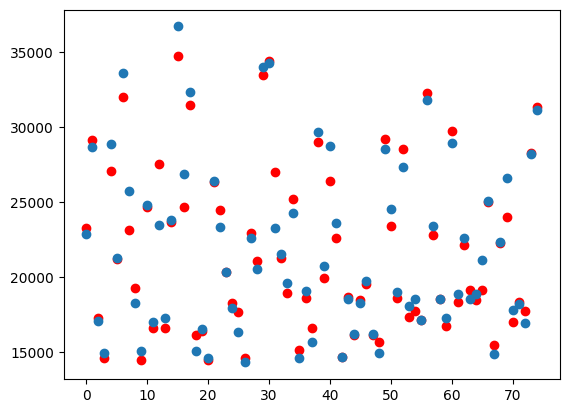

In [14]:

s=2500
l =75
ind = np.zeros(l)
for i in range(l):
    ind[i] = i
plt.scatter(ind, y_pred[s:s+l],color="red")
plt.scatter(ind, y_test[s:s+l])

In [15]:
time = datetime.datetime.now().strftime("%y-%m-%d_%H:%M")
f = f"../trainedModels/svr2_bayes_rbf_{time}"
pickle.dump(best_model, open(f, "wb"))